In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# 1. Load the CSV file
df = pd.read_csv('nigzn.csv', index_col=0)

# 2. Preprocess the data
X = df.drop(columns=['zn_mg'])  # Features
y = df['zn_mg']  # Target variable

# Handle missing values if necessary
X = X.fillna(X.mean())

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate scale_pos_weight to handle class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# 4. Train an XGBoost classification model
model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# 5. Optimize the model using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# 6. Predict on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# 7. Evaluate the model
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f'F1 Score: {f1}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC-ROC: {auc_roc}')


# 8. Plot SHAP values to interpret the model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
#shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=40)
#plt.figure()
#shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=40, show=False)
#plt.savefig('zincshap_summary_plot.png')
#plt.close()


Fitting 10 folds for each of 54 candidates, totalling 540 fits
F1 Score: 0.8110923854757162
Balanced Accuracy: 0.6418728238076545
Precision: 0.8169753086419753
Recall: 0.805293580772741
AUC-ROC: 0.7344417214586177


C:\Users\Uchenna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Uchenna\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


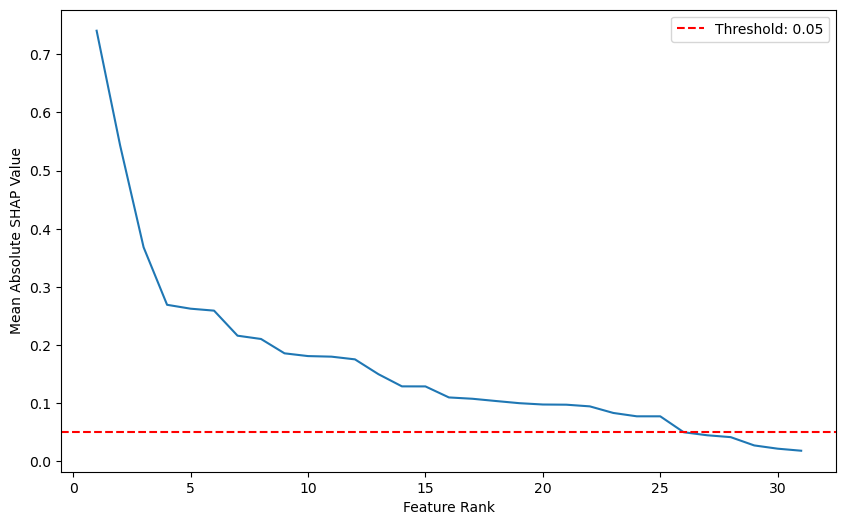

In [3]:

# Assuming you've already computed SHAP values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
shap_values_abs = np.abs(shap_values).mean(axis=0)
shap_values_abs_series = pd.Series(shap_values_abs, index=X_test.columns)

# Sort SHAP values in descending order
shap_values_abs_series = shap_values_abs_series.sort_values(ascending=False)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(shap_values_abs_series) + 1), y=shap_values_abs_series.values)

# Add red dashed line at y=0.05
plt.axhline(y=0.05, color='red', linestyle='--', label='Threshold: 0.05')

# Customize the plot
plt.xlabel('Feature Rank')
plt.ylabel('Mean Absolute SHAP Value')
plt.legend() 

# Save the plot as a PNG file
plt.savefig('zincelbow_plot_shap_values.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [21]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean SHAP Value': mean_shap_values
})

# Sort features by importance
shap_importance = shap_importance.sort_values(by='Mean SHAP Value', ascending=False)

# Save the SHAP values to a CSV file
shap_importance.to_csv('zincshapvaluesfull', index=False)

# Print the SHAP importance table
print(shap_importance)

                 Feature  Mean SHAP Value
30                hhsize         0.670514
31               meanage         0.597326
22         starchy_roots         0.576107
21             meat_fish         0.346851
28           pulses_nuts         0.273974
20         milk_products         0.270021
23                fruits         0.248614
26                 sugar         0.211244
27             oils_fats         0.200950
5              agrishort         0.189655
8                  urban         0.179421
25         grains_flours         0.169862
24            vegetables         0.166137
19  drinking_water_rainy         0.137312
29                spices         0.132381
17        home_ownership         0.129900
13            television         0.123387
18                toilet         0.107956
4             disability         0.107868
10                 radio         0.103095
1                    hle         0.095399
7                   loan         0.094212
2            hospital_1m         0

Fitting 10 folds for each of 54 candidates, totalling 540 fits
F1 Score: 0.8036179671930094
Balanced Accuracy: 0.628243267433152
Precision: 0.8099505562422744
Recall: 0.7973836324916337
AUC-ROC: 0.7156642234714244


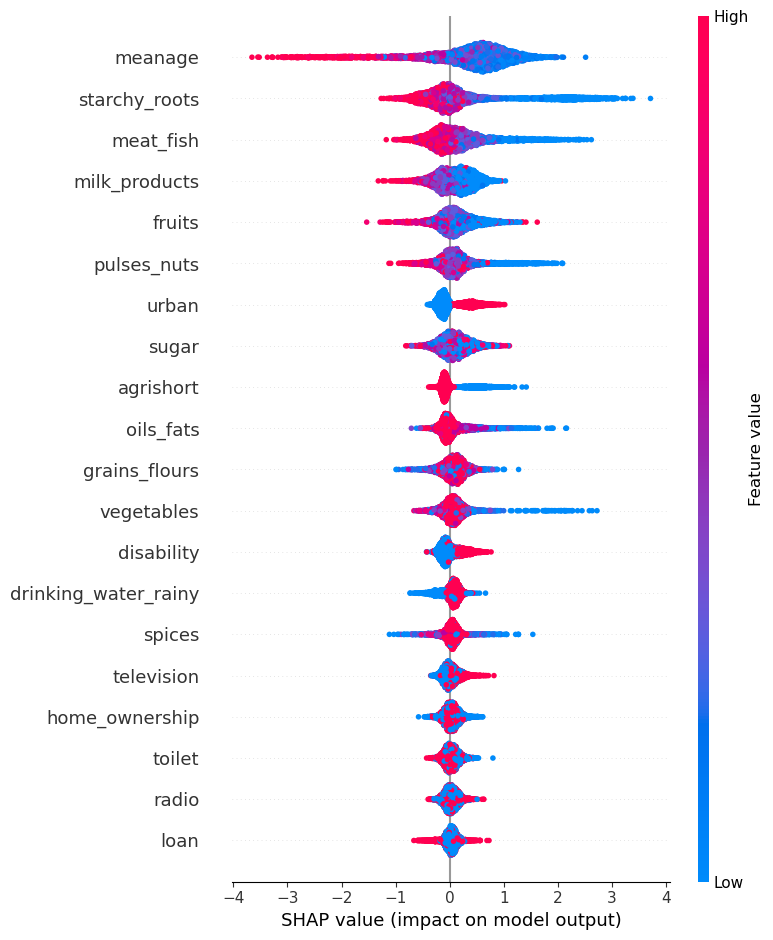

Fitting 10 folds for each of 54 candidates, totalling 540 fits

Filtered Model Performance:
F1 Score: 0.8052704151984065
Balanced Accuracy: 0.6306273293770214
Precision: 0.8111111111111111
Recall: 0.7995132339519319
AUC-ROC: 0.7148890688753088


In [1]:
# 1. Load the CSV file
df = pd.read_csv('nigzn.csv', index_col=0)

# 2. Preprocess the data
X = df.drop(columns=['zn_mg'])  # Features
y = df['zn_mg']  # Target variable

# Handle missing values if necessary
X = X.fillna(X.mean())

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate scale_pos_weight to handle class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# 4. Train an XGBoost classification model
model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)

# 5. Optimize the model using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='f1', verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# 6. Predict on the test data
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# 7. Evaluate the model
f1 = f1_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f'F1 Score: {f1}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC-ROC: {auc_roc}')

# 8. Plot SHAP values to interpret the model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="dot")

# 9. Apply the 0.1 SHAP value threshold
# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)
shap_importance = pd.DataFrame({'Feature': X_test.columns, 'Mean SHAP Value': mean_shap_values})
shap_importance = shap_importance.sort_values(by='Mean SHAP Value', ascending=False)

# Apply the 0.1 threshold
selected_features = shap_importance[shap_importance['Mean SHAP Value'] >= 0.05]['Feature']

# Filter the training and testing data
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

# Refit the model with the filtered features
filtered_model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight)
filtered_grid_search = GridSearchCV(estimator=filtered_model, param_grid=param_grid, cv=10, scoring='f1', verbose=1)
filtered_grid_search.fit(X_train_filtered, y_train)

# Best filtered model
best_filtered_model = filtered_grid_search.best_estimator_

# Predict on the test data with the filtered model
y_pred_filtered = best_filtered_model.predict(X_test_filtered)
y_pred_proba_filtered = best_filtered_model.predict_proba(X_test_filtered)[:, 1]  # Probability estimates for the positive class

# Evaluate the filtered model
f1_filtered = f1_score(y_test, y_pred_filtered)
balanced_acc_filtered = balanced_accuracy_score(y_test, y_pred_filtered)
precision_filtered = precision_score(y_test, y_pred_filtered)
recall_filtered = recall_score(y_test, y_pred_filtered)
auc_roc_filtered = roc_auc_score(y_test, y_pred_proba_filtered)

print(f'\nFiltered Model Performance:')
print(f'F1 Score: {f1_filtered}')
print(f'Balanced Accuracy: {balanced_acc_filtered}')
print(f'Precision: {precision_filtered}')
print(f'Recall: {recall_filtered}')
print(f'AUC-ROC: {auc_roc_filtered}')


                 Feature  Mean SHAP Value
0                meanage         0.776320
1          starchy_roots         0.563633
2              meat_fish         0.369183
3          milk_products         0.279624
5            pulses_nuts         0.271832
4                 fruits         0.270819
7                  sugar         0.224773
6                  urban         0.206803
9              oils_fats         0.187902
10         grains_flours         0.179087
11            vegetables         0.169307
8              agrishort         0.162175
12            disability         0.157371
13  drinking_water_rainy         0.146654
14                spices         0.137332
15            television         0.137234
20                   hle         0.105311
18                 radio         0.104560
21             telephone         0.101675
16        home_ownership         0.101580
17                toilet         0.099247
19                  loan         0.092010
22           hospital_1m         0

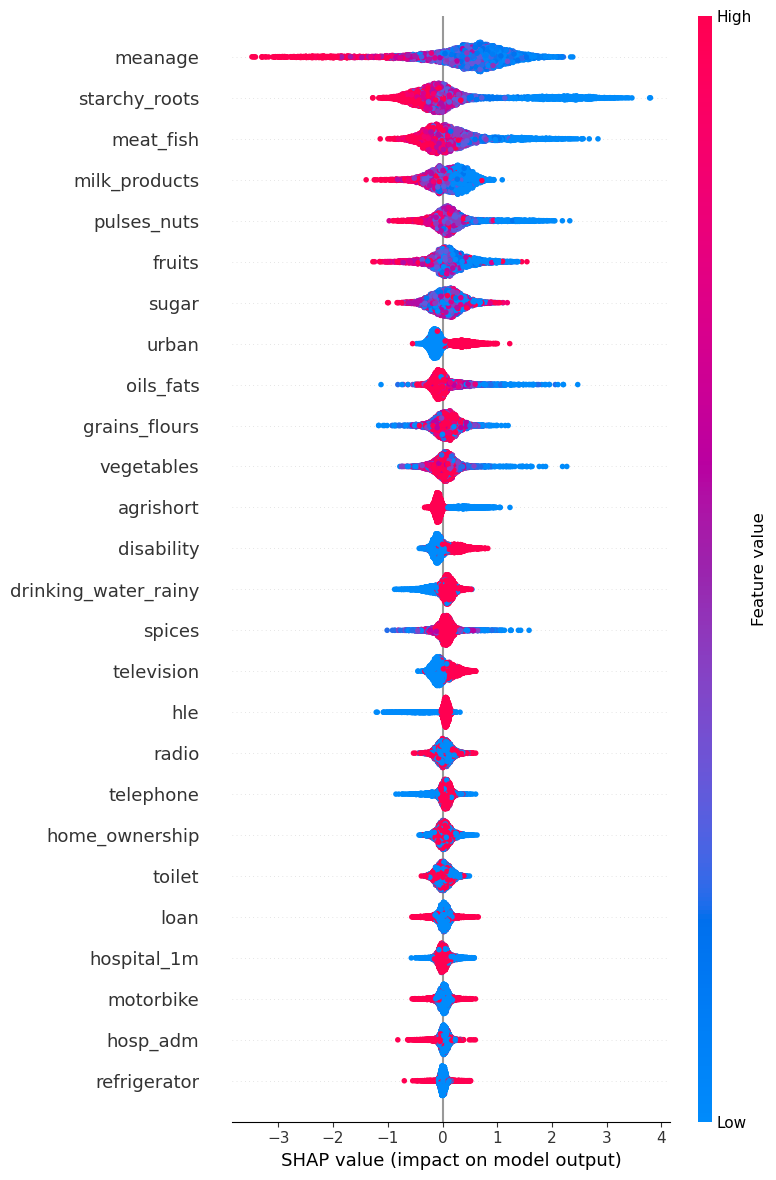

In [4]:
#Main
# Assuming you have already defined `best_filtered_model`, `X_test_filtered`, and `shap` library is imported

# Compute SHAP values
explainer = shap.TreeExplainer(best_filtered_model)
shap_values = explainer.shap_values(X_test_filtered)

# Calculate mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test_filtered.columns,
    'Mean SHAP Value': mean_shap_values
})

# Sort features by importance
shap_importance = shap_importance.sort_values(by='Mean SHAP Value', ascending=False)

# Save the SHAP values to a CSV file
shap_importance.to_csv('zincshapvalues_filtered.csv', index=False)

# Print the SHAP importance table
print(shap_importance)

# Generate and save SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_filtered, plot_type="dot", max_display=40, show=False)
plt.savefig('zincshap_summary_plot_filtered.png')
plt.close()
# Summary plot for all features used
shap.summary_plot(shap_values, X_test_filtered, plot_type="dot",max_display=40)

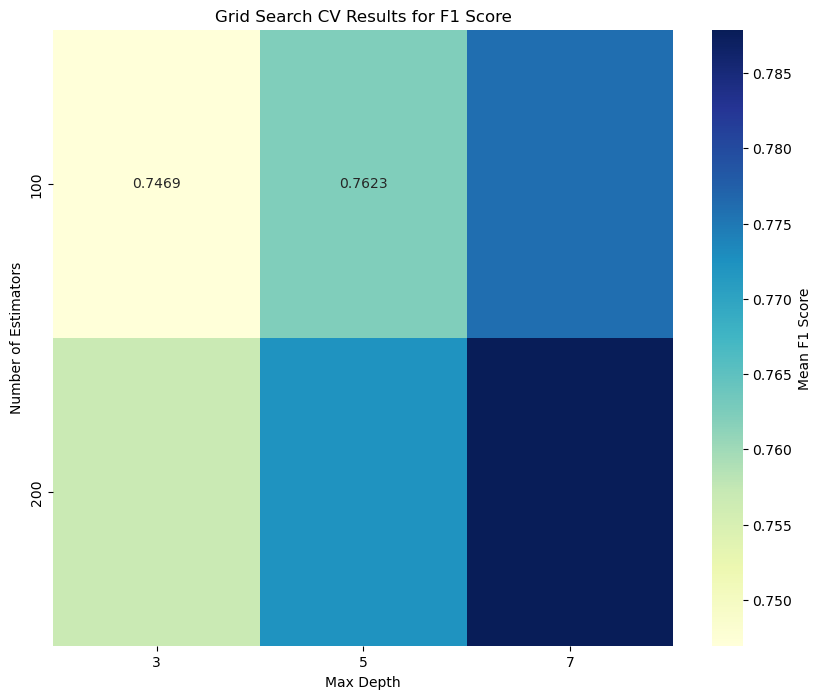

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert grid search results to a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Select columns relevant to hyperparameters and mean test score
results = results[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 
                   'mean_test_score', 'rank_test_score']]

# Pivot the DataFrame to make it easier to plot
pivot_table = results.pivot_table(values='mean_test_score', 
                                  index='param_n_estimators', 
                                  columns='param_max_depth', 
                                  aggfunc='mean')

# Plot the results
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".4g", cmap="YlGnBu", cbar_kws={'label': 'Mean F1 Score'})
plt.title('Grid Search CV Results for F1 Score')
plt.ylabel('Number of Estimators')
plt.xlabel('Max Depth')
plt.show()


In [5]:
#tanz wave 4
tanzdfid = pd.read_csv('tanzdfid.csv', index_col=0)
ids = tanzdfid[['y4_hhid']]  # Extract ID column
new_data = tanzdfid.drop(columns=['y4_hhid'])  # Drop ID column from new_data
tanzdfid_filtered = new_data[selected_features]

new_predictions = best_filtered_model.predict(tanzdfid_filtered)
new_predictions_proba = best_filtered_model.predict_proba(tanzdfid_filtered)[:, 1]  # Probability estimates for the positive class

# 5. Combine the IDs with the Predictions
predictions_df = pd.DataFrame({
    'Prediction': new_predictions,
    'Prediction_Probability': new_predictions_proba
}, index=new_data.index)  # Ensure indices align

combined_output = pd.concat([ids, predictions_df], axis=1)


In [6]:
# 1. Load the tanest.csv data
tanzest_data = pd.read_csv('tanzest.csv', index_col=0)

# 2. Merge combined_output with tanest.csv data on 'ID' in combined_output and 'y4_hhid' in tanest.csv
merged_data = pd.merge(combined_output, tanzest_data, on='y4_hhid', how='inner')

# 3. View the head of the merged DataFrame
print(merged_data.head())

# 4. (Optional) Save the merged DataFrame to a new CSV file
merged_data.to_csv('zincmerged_output.csv', index=False)

    y4_hhid  Prediction  Prediction_Probability  znadq  foladq
0  1000-001           0                0.322553      0       0
1  1001-001           1                0.980085      1       0
2  1002-001           1                0.996605      0       0
3  1003-001           1                0.904145      0       0
4  1005-001           1                0.954991      1       0


In [7]:
#tanz wave 5
tanzdfid = pd.read_csv('tanz2020_df.csv', index_col=0)
ids = tanzdfid[['y5_hhid']]  # Extract ID column
new_data = tanzdfid.drop(columns=['y5_hhid'])  # Drop ID column from new_data
tanzdfid_filtered = new_data[selected_features]

new_predictions = best_filtered_model.predict(tanzdfid_filtered)
new_predictions_proba = best_filtered_model.predict_proba(tanzdfid_filtered)[:, 1]  # Probability estimates for the positive class

# 5. Combine the IDs with the Predictions
predictions_df = pd.DataFrame({
    'Prediction': new_predictions,
    'Prediction_Probability': new_predictions_proba
}, index=new_data.index)  # Ensure indices align

combined_output = pd.concat([ids, predictions_df], axis=1)
combined_output.to_csv('zincwave5pred.csv', index=False)


F1 Score: 0.35224933842987355
Balanced Accuracy: 0.5376341890579769
Precision: 0.21965529886321966
Recall: 0.8887240356083086
AUC-ROC: 0.5610503498216862


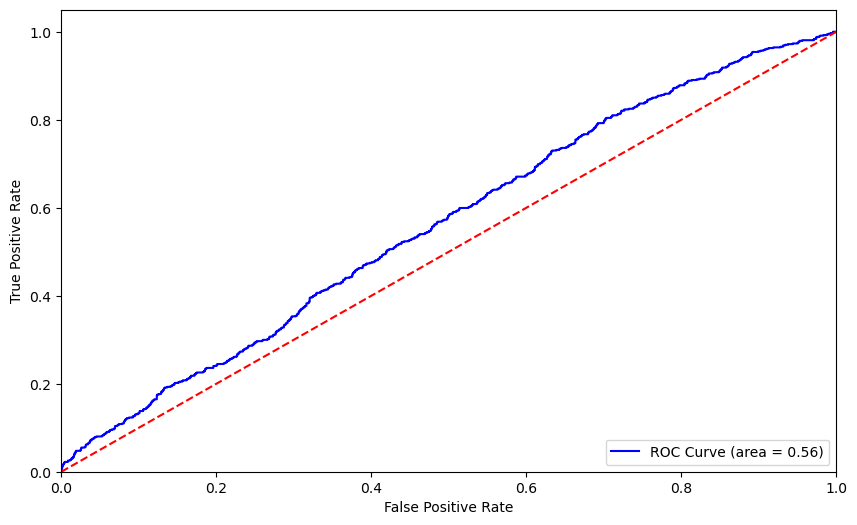

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    f1_score, 
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    roc_curve
)

# Extract the predicted values and true labels
y_pred = merged_data['Prediction']
y_true = merged_data['foladq']
y_prob = merged_data['Prediction_Probability']  # Probability estimates for the positive class

# Calculate performance metrics
f1 = f1_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_prob)  # Using the prediction probability for AUC-ROC

# Print the performance metrics
print(f'F1 Score: {f1}')
print(f'Balanced Accuracy: {balanced_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC-ROC: {auc_roc}')

# Generate and plot the AUC-ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the plot
plt.savefig('zincroc_curve.png')

# Show the plot
plt.show()
